# Estimate ESCO occupation exposure to impacts from COVID-19

We derived a simple estimate for occupational-level exposure to the impact from COVID-19 based on the
workers’ physical proximity to other people (determined from information in O\*NET) and on the extent to which
the work has to be performed on-site (measured by del Rio-Chanona et al.'s Remote Labor Index).

For example, the COVID-19 exposure score for concierge workers is high (0.75), as they normally have to work close to other people (‘at arm’s length’) and only one out of the seven concierge work activities can be performed remotely. We
occasionally used this exposure score to evaluate the origin and destination occupations.

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble.ipy

In [2]:
# Import crosswalk between ESCO and ONET
esco_onet_xwalk = pd.read_csv(data_folder + 'processed/ESCO_ONET_xwalk_full.csv')

# Import the remote labor index
occ_remote_labour = pd.read_csv(data_folder + 'processed/linked_data/ESCO_occupations_Remote_Labor_Index.csv')

# Import work context vectors
work_context_vectors = np.load(data_folder + 'interim/work_context_features/ESCO_work_context_vectors.npy')
print(work_context_vectors.shape)

# Import work context features
work_context_features = pd.read_csv(data_folder + 'processed/work_context_vector_features.csv')
work_context_features.sample(3)

(2942, 57)


,vector_element,element_name,element_id
8,8,Coordinate or Lead Others,4.C.1.b.1.g
10,10,Responsibility for Outcomes and Results,4.C.1.c.2
11,11,Frequency of Conflict Situations,4.C.1.d.1


# 1. Calculate a measure of exposure

Here, we follow a slightly modified but largely similar approach to [the ONS](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/articles/whichoccupationshavethehighestpotentialexposuretothecoronaviruscovid19/2020-05-11) and [NY Times](https://www.nytimes.com/interactive/2020/03/15/business/economy/coronavirus-worker-risk.html).

We take a geometric mean between:
- the rescaled `physical proximity` variable from O\*NET Work context features, and
- the `remote labor index` subtracted from 1. 

In [3]:
# We are interested in "Physical Proximity", which is the 20th element
work_context_features.loc[[20]]

,vector_element,element_name,element_id
20,20,Physical Proximity,4.C.2.a.3


In [4]:
# Relevant features: 20=Physical Proximity;
occupations_exposed = esco_onet_xwalk.copy()
occupations_exposed['physical_proximity'] = work_context_vectors[:, 20]
occupations_exposed = occupations_exposed.merge(occ_remote_labour[['id', 'remote_labor_index']], on='id', how='left')


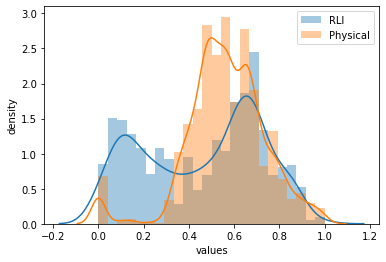

In [24]:
# Distributions of remote labor index and physical proximity
sns.distplot(occupations_exposed['remote_labor_index'], label='RLI', bins=np.linspace(0,1,25))
sns.distplot(occupations_exposed['physical_proximity'], label='Physical', bins=np.linspace(0,1,25))
plt.xlabel('values')
plt.ylabel('density')
plt.legend()
plt.show()

In [6]:
# COVID-19 exposure estimate
occupations_exposed['exposure_score'] = np.sqrt(occupations_exposed['physical_proximity'] * (1-occupations_exposed['remote_labor_index']))
occupations_exposed.sample(5)

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,physical_proximity,remote_labor_index,exposure_score
169,169,http://data.europa.eu/esco/occupation/0d9eed6b...,ammunition specialised seller,5223,41-2031.00,retail salespersons,0.6850,0.631579,0.502363
416,416,http://data.europa.eu/esco/occupation/21fe7141...,waterway construction labourer,9312,49-9071.00,"maintenance and repair workers, general",0.6925,0.161290,0.762107
1232,1232,http://data.europa.eu/esco/occupation/6667bf29...,residential home young people care worker,3412,21-1093.00,social and human service assistants,0.7900,0.615385,0.551222
184,184,http://data.europa.eu/esco/occupation/0ec62c2e...,refurbishing technician,7231,49-3021.00,automotive body and related repairers,0.4600,0.187500,0.611351
2658,2658,http://data.europa.eu/esco/occupation/e4ad2547...,dean of faculty,1345,11-9032.00,"education administrators, elementary and secon...",0.5225,0.714286,0.386375


# 2. Export

In [7]:
# Export the data
occupations_exposed.to_csv(data_folder + 'processed/linked_data/ESCO_occupations_COVID_Exposure.csv', index=False)
